# Klasifikacija žanra filma na osnovu njegovog postera

In [1]:
import pandas as pd
import numpy as np
import urllib
import PIL.Image
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn import model_selection
from random import sample
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

## Analiza podataka

Učitavamo podatke iz baze "41K movie posters from IMDB" koja se nalazi na [linku](https://www.kaggle.com/datasets/dadajonjurakuziev/movieposter?resource=download). 

In [2]:
data=pd.read_csv('duplicate_free_41K.csv')

In [3]:
data.shape

(41979, 19)

In [4]:
data.columns

Index(['id', 'poster', 'title', 'year', 'rating', 'genre', 'action',
       'adventure', 'animation', 'comedy', 'crime', 'drama', 'fantasy',
       'horror', 'mystery', 'romance', 'sci-fi', 'short', 'thriller'],
      dtype='object')

In [5]:
data.head()

,id,poster,title,year,rating,genre,action,adventure,animation,comedy,crime,drama,fantasy,horror,mystery,romance,sci-fi,short,thriller
0,0,https://m.media-amazon.com/images/M/MV5BNDM0ND...,Construction,2021,7.4,"comedy, romance",0,0,0,1,0,0,0,0,0,1,0,0,0
1,1,https://m.media-amazon.com/images/M/MV5BNTgyZD...,RED,2020,10.0,horror,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2,https://m.media-amazon.com/images/M/MV5BNGQzMT...,Huldra and Photographer,2020,10.0,"short, fantasy, horror",0,0,0,0,0,0,1,1,0,0,0,1,0
3,3,https://m.media-amazon.com/images/M/MV5BMWE2Yz...,Anti-dirt,2020,10.0,"short, action, comedy",1,0,0,1,0,0,0,0,0,0,0,1,0
4,4,https://m.media-amazon.com/images/M/MV5BOGI0Nz...,Asalu Em Jarigindhante,2020,10.0,drama,0,0,0,0,0,1,0,0,0,0,0,0,0


Baza sadrži linkove do postera filma i 13 žanrova koji su već binarno iskodirani.

In [6]:
sum(data['poster'].isna()) #proveravamo da li u podacima imamo Na vrednosti

0

In [7]:
sum(data['genre'].isna())

0

U bazi nema Na vrednosti

In [8]:
broj_zanrova=data.iloc[:,6:19].sum(axis=1).values

In [9]:
data = data.assign(broj_zanrova=broj_zanrova)
#dodajemo kolonu broj žanrova kako bismo videli ima li filmova koji nemaju nijedan žanr i kako bismo bolje ispitali podatke
    

In [10]:
data.head()

,id,poster,title,year,rating,genre,action,adventure,animation,comedy,crime,drama,fantasy,horror,mystery,romance,sci-fi,short,thriller,broj_zanrova
0,0,https://m.media-amazon.com/images/M/MV5BNDM0ND...,Construction,2021,7.4,"comedy, romance",0,0,0,1,0,0,0,0,0,1,0,0,0,2
1,1,https://m.media-amazon.com/images/M/MV5BNTgyZD...,RED,2020,10.0,horror,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,2,https://m.media-amazon.com/images/M/MV5BNGQzMT...,Huldra and Photographer,2020,10.0,"short, fantasy, horror",0,0,0,0,0,0,1,1,0,0,0,1,0,3
3,3,https://m.media-amazon.com/images/M/MV5BMWE2Yz...,Anti-dirt,2020,10.0,"short, action, comedy",1,0,0,1,0,0,0,0,0,0,0,1,0,3
4,4,https://m.media-amazon.com/images/M/MV5BOGI0Nz...,Asalu Em Jarigindhante,2020,10.0,drama,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [11]:
data.broj_zanrova.value_counts().sort_values()

1     8480
2    12417
3    21082
Name: broj_zanrova, dtype: int64

Svaki film ima zadat bar jedan žanr i najviše imamo filmova sa tri žanra

<BarContainer object of 3 artists>

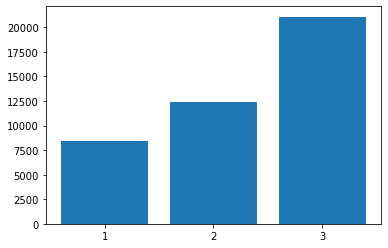

In [12]:
plt.bar(['1','2','3'],data.broj_zanrova.value_counts().sort_values().values)

In [13]:
data.iloc[:,6:19] #vidimo da imamo 13 žanrova i želimo da ispitamo kakva je izbalansiranost među njima


,action,adventure,animation,comedy,crime,drama,fantasy,horror,mystery,romance,sci-fi,short,thriller
0,0,0,0,1,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1,1,0,0,0,1,0
3,1,0,0,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41974,1,1,0,0,0,1,0,0,0,0,0,0,0
41975,1,1,0,1,0,0,0,0,0,0,0,0,0
41976,0,0,0,1,0,1,0,0,0,0,0,0,0
41977,0,0,0,0,0,0,0,1,0,0,0,0,1


In [14]:
data.iloc[:,6:19].sum(axis=0)
#posmatramo koliko filmova imamo od datih žanrova

action       10537
adventure     5693
animation     5318
comedy       14410
crime         6119
drama        16318
fantasy       3819
horror        7291
mystery       4760
romance       7432
sci-fi        3609
short         4155
thriller      7099
dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

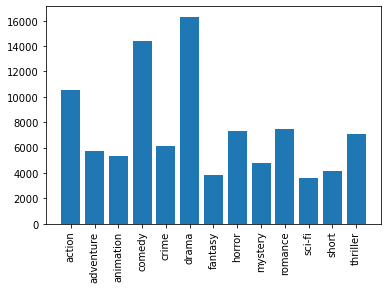

In [15]:
plt.bar(data.iloc[:,6:19].sum(axis=0).index,data.iloc[:,6:19].sum(axis=0).values)
plt.xticks(rotation='vertical')

Na histogramu uočavamo da su drama, komedija i akcija najučestaliji žanrovi i pokušaćemo da bar malo izbalansiramo
podatke kako bi se ova razlika smanjila. S obzirom da film može imati više različitih žanrova ne možemo nasumično smanjiti broj filmova sa vodecim žanrovima jer to može ugroziti i one manje zastupljene. 

Iz tog razloga, pogledaćemo sve kombinacije žanrova koje imamo i redukovati one kojih ima najviše gledajući da se ti žanrovi poklope sa žanrovima koji su iznad istaknuti kao najfrekventniji.

In [16]:
kombinacije_zanrova=pd.get_dummies(data.genre)

In [17]:
kombinacije_zanrova.shape #imamo 377 razlicitih kombinacija 

(41979, 377)

In [18]:
kombinacije_zanrova.sum(axis=0)

action                       453
action, adventure            106
action, adventure, comedy    673
action, adventure, crime     235
action, adventure, drama     433
                            ... 
short, romance, thriller       1
short, sci-fi                207
short, sci-fi, thriller       22
short, thriller               17
thriller                     802
Length: 377, dtype: int64

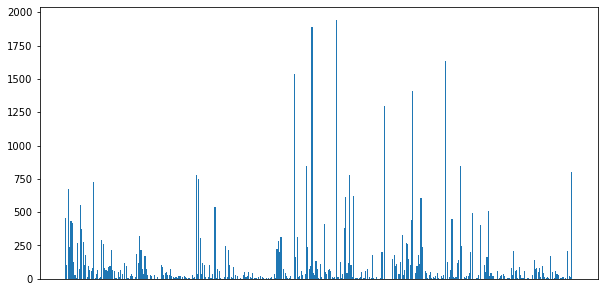

In [19]:
plt.figure(figsize=(10, 5))
plt.bar(kombinacije_zanrova.sum(axis=0).index,kombinacije_zanrova.sum(axis=0).values)
plt.xticks(ticks=[])
plt.show()

Na grafiku iznad uočavamo da su neke kombinacije žanrova dosta učestalije pa ćemo sortirati podatke kako bismo videli o kojim
kombinacijama je reč.

In [20]:
kombinacije_zanrova.sum(axis=0).sort_values(ascending=False).head(15)

comedy, romance                 1942
comedy, drama, romance          1886
horror                          1634
comedy                          1533
drama, romance                  1408
drama                           1294
horror, thriller                 847
comedy, drama                    844
thriller                         802
animation                        780
crime, drama, mystery            779
animation, action, adventure     746
action, crime, drama             725
action, adventure, comedy        673
crime, drama, thriller           623
dtype: int64

Vidimo da u vodećim kombinacijama ima dosta pojavljivanja komedije i drame.S obzirom da su ova dva žanra najfrekventnija,
redukovanje kombinacija koje ih sadrže će doprineti da histogram frekvencije pojedinačnih žanrova bude izbalansiraniji.

In [21]:
#beležimo sve indekse iz baze čiji filmovi imaju željene kombinacije žanrova

In [22]:
indeksi_comedy_romance=data[data.comedy==1][data.romance==1][data.broj_zanrova==2].index
indeksi_comedy_drama_romance=data[data.comedy==1][data.drama==1][data.romance==1][data.broj_zanrova==3].index
indeksi_horror=data[data.horror==1][data.broj_zanrova==1].index
indeksi_comedy=data[data.comedy==1][data.broj_zanrova==1].index
indeksi_drama_romance=data[data.drama==1][data.romance==1][data.broj_zanrova==2].index
indeksi_drama=data[data.drama==1][data.broj_zanrova==1].index
indeksi_horror_thriller=data[data.horror==1][data.thriller==1][data.broj_zanrova==2].index
indeksi_comedy_drama=data[data.comedy==1][data.drama==1][data.broj_zanrova==2].index
indeksi_crime_drama_mistery=data[data.crime==1][data.drama==1][data.mystery==1][data.broj_zanrova==3].index
indeksi_action_crime_drama=data[data.crime==1][data.drama==1][data.action==1][data.broj_zanrova==3].index
indeksi_action_adventure_comedy=data[data.adventure==1][data.comedy==1][data.action==1][data.broj_zanrova==3].index
indeksi_crime_drama_thriller=data[data.crime==1][data.drama==1][data.thriller==1][data.broj_zanrova==3].index

<ipython-input-22-a6d3b75b64ef>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  indeksi_comedy_romance=data[data.comedy==1][data.romance==1][data.broj_zanrova==2].index
<ipython-input-22-a6d3b75b64ef>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  indeksi_comedy_romance=data[data.comedy==1][data.romance==1][data.broj_zanrova==2].index
<ipython-input-22-a6d3b75b64ef>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  indeksi_comedy_drama_romance=data[data.comedy==1][data.drama==1][data.romance==1][data.broj_zanrova==3].index
<ipython-input-22-a6d3b75b64ef>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  indeksi_comedy_drama_romance=data[data.comedy==1][data.drama==1][data.romance==1][data.broj_zanrova==3].index
<ipython-input-22-a6d3b75b64ef>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  indeksi_comedy_drama_romance=data[dat

Takođe, iz podataka ćemo izbaciti one kombinacije koje se pojavljuju samo jednom kako bismo osigurali da u trening skupu imamo predstavnika svake od kombinacija.

In [23]:
kombinacije_zanrova.sum(axis=0).sort_values(ascending=True).head(40)

crime, mystery, drama            1
adventure, crime, horror         1
horror, comedy, action           1
adventure, comedy, thriller      1
animation, romance, sci-fi       1
adventure, comedy, mystery       1
animation, short, crime          1
fantasy, animation               1
drama, romance, adventure        1
drama, crime, romance            1
drama, crime, mystery            1
drama, crime                     1
drama, adventure                 1
drama, action                    1
short, mystery, romance          1
short, horror, comedy            1
crime, thriller, drama           1
crime, sci-fi, drama             1
crime, romance, sci-fi           1
adventure, crime, sci-fi         1
short, romance, thriller         1
animation, crime, horror         1
animation, adventure, mystery    1
short, crime, sci-fi             1
animation, crime                 1
mystery, drama                   1
animation, crime, thriller       1
animation, fantasy, thriller     1
animation, adventure

U liniji koda ispod izvukli smo indekse svih kombinacija za koje je program rekao da se pojavljuju samo jednom. Međutim, kako programu žanr [komedija,drama] nije isto što i [drama,komedija] neki od nizova ispod su imali više od jednog člana. Nakon provere broja članova u svakom od nizova, pod komentar su stavljeni oni koji imaju više od jednog člana.

In [24]:
#indeksi_crime_mystery_drama=data[data.crime==1][data.mystery==1][data.drama==1][data.broj_zanrova==3].index
indeksi_adventure_crime_horror=data[data.adventure==1][data.crime==1][data.horror==1][data.broj_zanrova==3].index
#indeksi_horror_comedy_action=data[data.horror==1][data.comedy==1][data.action==1][data.broj_zanrova==3].index
indeksi_adventure_comedy_triller=data[data.comedy==1][data.adventure==1][data.thriller==1][data.broj_zanrova==3].index
indeksi_animation_romance_sci=data[data.animation==1][data.romance==1][data['sci-fi']==1][data.broj_zanrova==3].index
indeksi_adventure_comedy_mystery=data[data.adventure==1][data.comedy==1][data.mystery==1][data.broj_zanrova==3].index
indeksi_animation_short_crime=data[data.animation==1][data.short==1][data.crime==1][data.broj_zanrova==3].index
#indeksi_animation_fantasy=data[data.animation==1][data.fantasy==1][data.broj_zanrova==2].index
#indeksi_drama_romance_adventure=data[data.adventure==1][data.drama==1][data.romance==1][data.broj_zanrova==3].index
#indeksi_drama_romance_crime=data[data.crime==1][data.drama==1][data.romance==1][data.broj_zanrova==3].index
#indeksi_drama_mystery_crime=data[data.crime==1][data.drama==1][data.mystery==1][data.broj_zanrova==3].index
#indeksi_drama_crime=data[data.crime==1][data.drama==1][data.broj_zanrova==2].index
#indeksi_drama_adventure=data[data.adventure==1][data.drama==1][data.broj_zanrova==2].index
#indeksi_drama_action=data[data.action==1][data.drama==1][data.broj_zanrova==2].index
#indeksi_short_horror_comedy=data[data.short==1][data.comedy==1][data.horror==1][data.broj_zanrova==3].index
indeksi_short_mystery_romance=data[data.short==1][data.mystery==1][data.romance==1][data.broj_zanrova==3].index
#indeksi_crime_thriller_drama=data[data.crime==1][data.thriller==1][data.drama==1][data.broj_zanrova==3].index
#indeksi_crime_sci_drama=data[data.crime==1][data['sci-fi']==1][data.drama==1][data.broj_zanrova==3].index
indeksi_crime_sci_romance=data[data.crime==1][data['sci-fi']==1][data.romance==1][data.broj_zanrova==3].index
indeksi_crime_sci_adventure=data[data.crime==1][data['sci-fi']==1][data.adventure==1][data.broj_zanrova==3].index
indeksi_short_romance_thriller=data[data.short==1][data.thriller==1][data.romance==1][data.broj_zanrova==3].index
indeksi_animation_horror_crime=data[data.animation==1][data.horror==1][data.crime==1][data.broj_zanrova==3].index
indeksi_animation_adventure_mystery=data[data.animation==1][data.adventure==1][data.mystery==1][data.broj_zanrova==3].index
indeksi_crime_sci_short=data[data.crime==1][data['sci-fi']==1][data.short==1][data.broj_zanrova==3].index
indeksi_animation_crime=data[data.animation==1][data.crime==1][data.broj_zanrova==2].index
#indeksi_mystery_drama=data[data.mystery==1][data.drama==1][data.broj_zanrova==2].index
indeksi_animation_thriller_crime=data[data.animation==1][data.thriller==1][data.crime==1][data.broj_zanrova==3].index
indeksi_animation_thriller_fantasy=data[data.animation==1][data.thriller==1][data.fantasy==1][data.broj_zanrova==3].index
#indeksi_animation_adventure_action=data[data.animation==1][data.adventure==1][data.action==1][data.broj_zanrova==3].index
indeksi_short_thriller_crime=data[data.short==1][data.thriller==1][data.crime==1][data.broj_zanrova==3].index
indeksi_animation_thriller_horror=data[data.animation==1][data.thriller==1][data.horror==1][data.broj_zanrova==3].index
indeksi_animation_mystery_romance=data[data.animation==1][data.mystery==1][data.romance==1][data.broj_zanrova==3].index
#indeksi_horror_sci_mystery=data[data.horror==1][data['sci-fi']==1][data.mystery==1][data.broj_zanrova==3].index
#indeksi_action_sci=data[data.action==1][data['sci-fi']==1][data.broj_zanrova==2].index
#indeksi_romance_comedy_fantasy=data[data.romance==1][data.comedy==1][data.fantasy==1][data.broj_zanrova==3].index
#indeksi_romance_comedy=data[data.romance==1][data.comedy==1][data.broj_zanrova==2].index
indeksi_adventure_romance_horror=data[data.adventure==1][data.romance==1][data.horror==1][data.broj_zanrova==3].index


<ipython-input-24-b9c9bbaf78fb>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  indeksi_adventure_crime_horror=data[data.adventure==1][data.crime==1][data.horror==1][data.broj_zanrova==3].index
<ipython-input-24-b9c9bbaf78fb>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  indeksi_adventure_crime_horror=data[data.adventure==1][data.crime==1][data.horror==1][data.broj_zanrova==3].index
<ipython-input-24-b9c9bbaf78fb>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  indeksi_adventure_crime_horror=data[data.adventure==1][data.crime==1][data.horror==1][data.broj_zanrova==3].index
<ipython-input-24-b9c9bbaf78fb>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  indeksi_adventure_comedy_triller=data[data.comedy==1][data.adventure==1][data.thriller==1][data.broj_zanrova==3].index
<ipython-input-24-b9c9bbaf78fb>:4: UserWarning: Boolean Series key will be reindexed to

In [25]:
indeksi_za_izbacivanje=np.array([]) #pravimo niz indeksa koje treba izbaciti

In [26]:
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_adventure_crime_horror)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_adventure_comedy_triller)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_animation_romance_sci)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_adventure_comedy_mystery)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_animation_short_crime)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_short_mystery_romance)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_crime_sci_romance)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_crime_sci_adventure)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_short_romance_thriller)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_animation_horror_crime)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_animation_adventure_mystery)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_crime_sci_short)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_animation_crime)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_animation_thriller_crime)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_animation_thriller_fantasy)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_short_thriller_crime)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_animation_thriller_horror)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_animation_mystery_romance)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_adventure_romance_horror)

In [27]:
indeksi_za_izbacivanje

array([13386., 40906., 30091.,  3189., 29445., 39041.,  1812.,  1152.,
        6644., 21250., 41793., 10981., 29218., 12435., 24077.,  1149.,
       17257., 17491., 34875.])

S obzirom da filmovi sa 3 žanra čine većinski deo podataka pogledacemo i kako izgleda njihova raspodela.

In [22]:
kombinacije_tri_zanra=kombinacije_zanrova.assign(broj_zanrova=broj_zanrova)[broj_zanrova==3]

In [23]:
kombinacije_tri_zanra=kombinacije_tri_zanra.drop(columns=['broj_zanrova'])

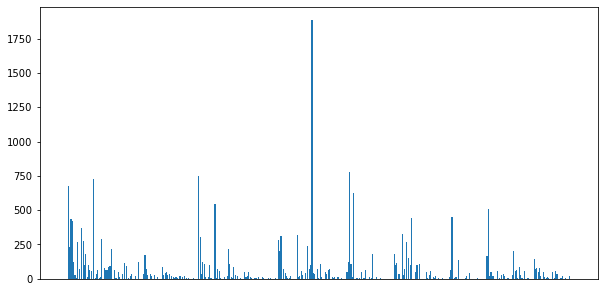

In [24]:
plt.figure(figsize=(10, 5))
plt.bar(kombinacije_tri_zanra.sum(axis=0).index,kombinacije_tri_zanra.sum(axis=0).values)
plt.xticks(ticks=[])
plt.show()

In [25]:
kombinacije_tri_zanra.sum(axis=0).sort_values(ascending=False).head(15)

comedy, drama, romance          1886
crime, drama, mystery            779
animation, action, adventure     746
action, crime, drama             725
action, adventure, comedy        673
crime, drama, thriller           623
animation, adventure, comedy     542
short, action, comedy            508
horror, mystery, thriller        450
drama, mystery, thriller         443
action, adventure, drama         433
action, adventure, fantasy       418
action, comedy, crime            370
drama, horror, mystery           327
comedy, crime, drama             316
dtype: int64

Vidimo da i ovde ima dosta neizbalansiranosti. Najviše ima filmova sa žanrom komedija, drama, romansa, ali kako je to i drugi najzastupljeniji žanr svakako ćemo njegov broj smanjiti, što će učiniti da prethodni histogram izgleda bolje.
Na osnovu svih dobijenih rezultata, na slučajan način biramo podskupove izdvojenih indeksa odredjene veličine i njih smeštamo u niz indeksa koje ćemo kasnije izbaciti iz podataka. Veličina podskupova je izabrana u zavisnosti od broja filmova sa datim žanrom i od toga na koje se žanrove treba fokusirati prilikom redukcije.


In [28]:
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,sample(list(indeksi_comedy_romance),1200))
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,sample(list(indeksi_comedy_drama_romance),1200))
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,sample(list(indeksi_horror),600))
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,sample(list(indeksi_comedy),800))
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,sample(list(indeksi_drama_romance),500))
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,sample(list(indeksi_drama),800))
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,sample(list(indeksi_horror_thriller),200))
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,sample(list(indeksi_comedy_drama),400))
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,sample(list(indeksi_crime_drama_mistery),300))
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,sample(list(indeksi_action_adventure_comedy),200))
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,sample(list(indeksi_action_crime_drama),300))
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,sample(list(indeksi_crime_drama_thriller),200))

In [29]:
indeksi_za_izbacivanje.shape

(6719,)

Vidimo da imamo 6719 instanci koje ćemo izbaciti iz početnog skupa. Ovaj broj nije konačan jer postoji mogućnost da nisu svi linkovi do postera ispravni, stoga ćemo i njih izbaciti ukoliko bude potrebe.

In [30]:
data.shape

(41979, 20)

In [31]:
data.drop(indeksi_za_izbacivanje,inplace=True)

In [32]:
data.shape  #ostajemo na bazi koja ima 35260 instanci

(35260, 20)

Pogledajmo trenutnu raspodelu žanrova kako bismo se uverili da se situacija poboljšala.


In [33]:
data.iloc[:,6:19].sum(axis=0)

action       10037
adventure     5487
animation     5309
comedy       10608
crime         5310
drama        12618
fantasy       3818
horror        6487
mystery       4456
romance       4526
sci-fi        3605
short         4150
thriller      6693
dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

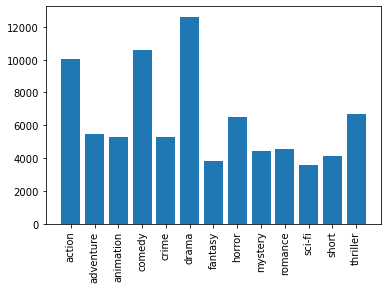

In [34]:
plt.bar(data.iloc[:,6:19].sum(axis=0).index,data.iloc[:,6:19].sum(axis=0).values)
plt.xticks(rotation='vertical')

Na stubićima se i dalje uočavaju razlike između žanrova, ali su one manje izražene nego pre. Svakako ne treba težiti da svi stubići budu jednaki jer ovakvi podaci predstavljaju realnu sliku (s obzirom da komedija, drama i akcija jesu najčešći žanrovi).
Cilj je bio samo smanjiti razlike kako bi naš model mogao da nauči što bolje svaki od žanrova.

Na graficima ispod svakako vidimo da smo redukovanjem poboljšali i stubiće svih kombinacija žanrova kao i stubiće filmova sa 3 žanra.

In [35]:
kombinacije_zanrova=pd.get_dummies(data.genre)

In [36]:
kombinacije_zanrova.sum(axis=0)

action                       453
action, adventure            106
action, adventure, comedy    473
action, adventure, crime     235
action, adventure, drama     433
                            ... 
short, romance, sci-fi         7
short, sci-fi                207
short, sci-fi, thriller       22
short, thriller               17
thriller                     802
Length: 356, dtype: int64

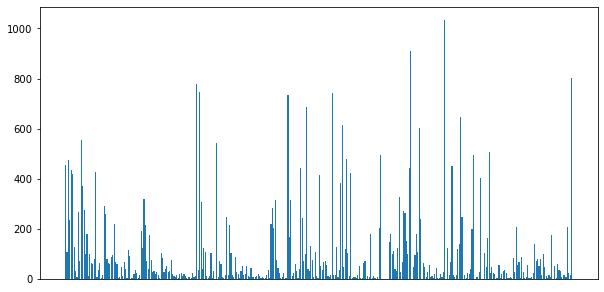

In [37]:
plt.figure(figsize=(10, 5))
plt.bar(kombinacije_zanrova.sum(axis=0).index,kombinacije_zanrova.sum(axis=0).values)
plt.xticks(ticks=[])
plt.show()

In [38]:
broj_zanrova=data.iloc[:,6:19].sum(axis=1).values

In [39]:
kombinacije_tri_zanra=kombinacije_zanrova.assign(broj_zanrova=broj_zanrova)[broj_zanrova==3]
kombinacije_tri_zanra=kombinacije_tri_zanra.drop(columns='broj_zanrova')


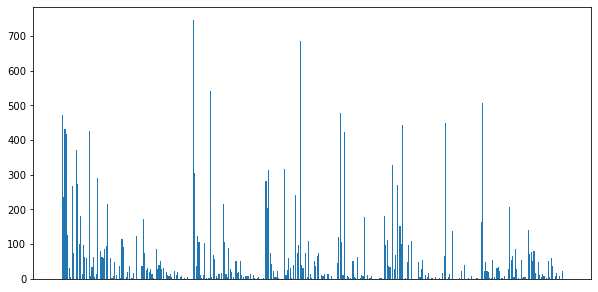

In [40]:
plt.figure(figsize=(10, 5))
plt.bar(kombinacije_tri_zanra.sum(axis=0).index,kombinacije_tri_zanra.sum(axis=0).values)
plt.xticks(ticks=[])
plt.show()

In [41]:
#data

,id,poster,title,year,rating,genre,action,adventure,animation,comedy,crime,drama,fantasy,horror,mystery,romance,sci-fi,short,thriller,broj_zanrova
1,1,https://m.media-amazon.com/images/M/MV5BNTgyZD...,RED,2020,10.0,horror,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,2,https://m.media-amazon.com/images/M/MV5BNGQzMT...,Huldra and Photographer,2020,10.0,"short, fantasy, horror",0,0,0,0,0,0,1,1,0,0,0,1,0,3
3,3,https://m.media-amazon.com/images/M/MV5BMWE2Yz...,Anti-dirt,2020,10.0,"short, action, comedy",1,0,0,1,0,0,0,0,0,0,0,1,0,3
5,5,https://m.media-amazon.com/images/M/MV5BNDU3YT...,The Zone of Twilight,2020,9.9,"action, horror, sci-fi",1,0,0,0,0,0,0,1,0,0,1,0,0,3
6,6,https://m.media-amazon.com/images/M/MV5BZThmOW...,Hollywood,2020,9.8,"comedy, crime",0,0,0,1,1,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41969,42011,https://m.media-amazon.com/images/M/MV5BMTU3OD...,The Sopranos: Road to Respect,2006,6.2,"action, adventure, crime",1,1,0,0,1,0,0,0,0,0,0,0,0,3
41970,42012,https://m.media-amazon.com/images/M/MV5BYzhlND...,Dragon Tiger Gate,2006,6.2,"action, drama, fantasy",1,0,0,0,0,1,1,0,0,0,0,0,0,3
41971,42013,https://m.media-amazon.com/images/M/MV5BMzY1MT...,All the King's Men,2006,6.2,"drama, thriller",0,0,0,0,0,1,0,0,0,0,0,0,1,2
41974,42016,https://m.media-amazon.com/images/M/MV5BMTgxNz...,Demon Empire,2006,6.2,"action, adventure, drama",1,1,0,0,0,1,0,0,0,0,0,0,0,3


In [42]:
#popravljamo indekse da idu od 0 do 35278

In [42]:
data['indeks'] = range(35260) #dodajemo novu kolonu koja predstavlja brojeve od 0 do 35278 

In [43]:
data=data.set_index(['indeks']) #postavljamo je da bude u svojstvu indeksa

### Učitavanje postera

Svi posteri su zadati preko linkova koji se nalaze u bazi. Slike učitavamo u listu i obraćamo pažnju na one linkove koji vraćaju neku grešku. Te redove ćemo izbaciti iz naših podataka.

In [45]:
putanja_do_slika=data.poster

In [46]:
putanja_do_slika.shape

(35260,)

In [47]:
slike=[]
indeksi_neispravnih_linkova=[]
iterator=0

In [48]:
for i in putanja_do_slika:
    try:
        urllib.request.urlretrieve(i, "slika.png")
        img=PIL.Image.open("slika.png").convert("RGBA")
        slike.append(img)
        iterator=iterator+1
    except:
        indeksi_neispravnih_linkova.append(iterator)
        iterator=iterator+1

In [49]:
len(slike) #ukupno imamo 34963 postera

34963

In [50]:
len(indeksi_neispravnih_linkova)  #broj redova koje je potrebno da izbacimo iz podataka

297

In [52]:
data.drop(index=indeksi_neispravnih_linkova, inplace=True) #izbacujemo neispravne redove

In [53]:
data.shape 

(34963, 20)

Završili smo sa čišćenjem podataka i vidimo da sada naša baza ima 34963 instanci.

## Priprema podataka za model

Naša zavisna promeljiva predstavlja binarni vektor dužine 13. Svaka pozicija odgovara određenom žanru filma. Film je onih žanrova koji imaju jedinicu na svojim pozicijama.

Uz pomoć binarno kodiranih kolona koje se već nalaze u tabeli, definišemo našu zavisnu promenljivu y.

In [55]:
data.iloc[:,6:19].values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int64)

In [56]:
y=[]

In [57]:
for i in data.iloc[:,6:19].values:
    y.append(i)

In [59]:
imena_klasa=list(data.columns[6:19])

In [60]:
imena_klasa

['action',
 'adventure',
 'animation',
 'comedy',
 'crime',
 'drama',
 'fantasy',
 'horror',
 'mystery',
 'romance',
 'sci-fi',
 'short',
 'thriller']

In [61]:
#funkcija koja vraca zanr filma na osnovu binarno kodiranog vektora
#ova funkcija nam sluzi za ilustraciju nasih podataka za model
def zanr(niz):
    zanr=[]
    for i in range(len(niz)):
        if(niz[i]==1):
            zanr.append(imena_klasa[i])
        else:
            None
    return zanr        
            

U narednim linijama koda prikazano je kako izgledaju podaci za naš model, dve nasumične slike iz učitane liste slika, kao i vektor zavisne promenljive koji ide uz njih.

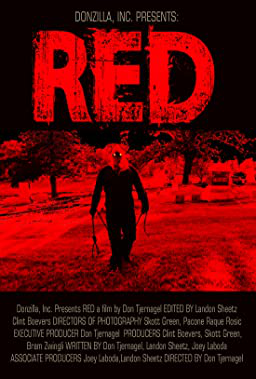

In [62]:
slike[0]

In [63]:
y[0]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], dtype=int64)

In [64]:
zanr(y[0]) #pozivamo funkciju koja ce nam procitati zanr

['horror']

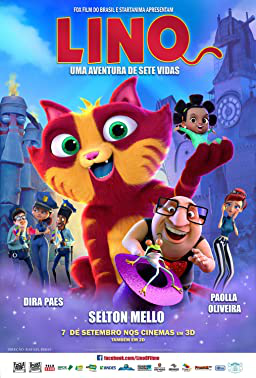

In [74]:
slike[11258]

In [75]:
y[11258]

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [76]:
zanr(y[11258])

['adventure', 'animation', 'comedy']

Menjamo veličinu slika kako bi sve slike bile istih dimenzija. Smanjujemo ih da bi mreža imala manje parametara i da bi bila
lakša za treniranje.

In [77]:
for brojac in range(len(slike)):
    slike[brojac]=slike[brojac].resize(size=(128,128))

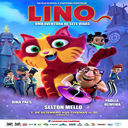

In [80]:
slike[11258] #prikaz kako slika izgleda nakon promene veličine

In [81]:
slike[11260].mode #proveravamo kako su slike zadate

'RGBA'

Slike imaju i alfa kanal koji ćemo ukloniti.

In [82]:
for brojac in range(len(slike)):
    slike[brojac]=slike[brojac].convert('RGB')

In [83]:
slike[5466].mode

'RGB'

Delimo podatke na trening, validaciju i test skup. 85% podataka će biti u trening skupu, a 15% u test skupu. 15% od trening skupa će biti u validacioni skup. Prilikom podele podataka pazimo da kombinacije žanrova budu ravnomerno raspodeljene i u trening i u test skupu i iz tog razloga podešavamo stratify=y.

In [192]:
X_train_val, X_test, y_train_val, y_test = model_selection.train_test_split(slike,y, test_size=0.15,stratify=y)

In [193]:
X_train, X_validation, y_train, y_validation=model_selection.train_test_split(X_train_val,y_train_val, test_size=0.15)

In [194]:
print(len(X_train),len(X_test),len(X_validation),len(y_train),len(y_test),len(y_validation)) #veličine skupova

25260 5245 4458 25260 5245 4458


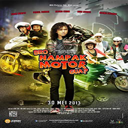

In [197]:
X_test[0]

In [198]:
y_test[0]

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [199]:
zanr(y_test[0])

['action', 'comedy']

X_train, X_validation i X_test su liste slika, a y_train i y_test su liste nizova. Prvo pretvaramo slike u nizove.

In [200]:
for brojac in range(len(X_test)):
    X_test[brojac]=np.asarray(X_test[brojac])

In [201]:
for brojac in range(len(X_train)):
    X_train[brojac]=np.asarray(X_train[brojac])

In [202]:
for brojac in range(len(X_validation)):
    X_validation[brojac]=np.asarray(X_validation[brojac])

Nakon toga, pošto sad imamo liste nizova, konvertujemo liste u nizove.

In [204]:
X_test=np.asarray(X_test)

In [205]:
X_train=np.asarray(X_train)

In [206]:
X_validation=np.asarray(X_validation)

In [128]:
#normalizacija slika i promena iz uint8 u float32. Slike normalizujemo na ovaj način jer je ovakav format korišćen za 
#treniranje ugradjene ResNet50 mreže

In [207]:
X_test = X_test.astype('float32')
X_test /= 127.5
X_test= X_test-1

In [208]:
X_train = X_train.astype('float32')
X_train /= 127.5
X_train= X_train-1

In [209]:
X_validation = X_validation.astype('float32')
X_validation /= 127.5
X_validation= X_validation-1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


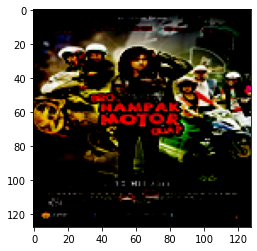

In [210]:
plt.imshow(X_test[0]) #slike sada možemo videti korišćenjem paketa matplotlib

In [211]:
X_test.shape

(5245, 128, 128, 3)

In [213]:
X_train.shape #vidimo da ćemo za trening mreže imati 25260 slika dimenzije (128,128,3)

(25260, 128, 128, 3)

In [214]:
X_validation.shape

(4458, 128, 128, 3)

In [215]:
y_train=np.asarray(y_train) #prebacujemo i y_train, y_validation  i y_test u niz nizova
y_test=np.asarray(y_test)
y_validation=np.asarray(y_validation)

In [216]:
y_train.shape

(25260, 13)

In [217]:
y_validation.shape

(4458, 13)

In [218]:
y_test.shape

(5245, 13)

## Pravljenje modela

In [219]:
velicina_ulaza=(128,128,3)

In [220]:
broj_klasa=13 

In [221]:
model_resnet50= Sequential()

Koristimo prethodno istrenirani ResNet50 model. Sve konvolutivne neuronske mreže u početnim slojevima uče osnovne/slične paterne, iz tog razloga koristešćenje već istreniranih modela pravi veliku uštedu vremena. Takođe, ovi modeli su trenirani na ogromnoj količini podataka koju bi bilo teško obezbediti ako bismo sami trenirali ceo model. Praksa kod već istreniranih modela je da njihove težine iz konvolutivnog dela mreže fiksiramo, a da težine iz potpuno povezanog dela sami treniramo.

In [222]:
pretrained_model=ResNet50(weights='imagenet',include_top=False,input_shape=velicina_ulaza, classes= broj_klasa)
for layer in pretrained_model.layers:
    layer.trainable=False #fiksiramo slojeve mreže koje ne želimo da treniramo

In [223]:
model_resnet50.add(pretrained_model)

In [224]:
model_resnet50.add(Flatten())

In [225]:
model_resnet50.add(Dense(512, activation='relu'))
model_resnet50.add(Dropout(0.5))
model_resnet50.add(Dense(13, activation='sigmoid'))

In [226]:
model_resnet50.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dense_8 (Dense)             (None, 512)               16777728  
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 13)                6669      
                                                                 
Total params: 40,372,109
Trainable params: 16,784,397
Non-trainable params: 23,587,712
_________________________________________________________________


Naša mreža sastoji se od ResNet50 slojeva koji imaju više od 23 miliona parametara. Na to smo dodali sloj koji ispravlja izlaz iz konvolutivnog dela mreže, gusti sloj od 512 čvorova, dropout sloj koji služi da spreči preprilagođavanje i izlazni sloj koji ima 13 neurona (jer toliko imamo žanrova) i sigmoidnu aktivacionu funkciju (kako bismo svakom žanru dodelili verovatnoću).

Dropout sloj smo dodali nakon treniranja modela sa istom preostalom arhitekturom, ali bez ovog sloja. Kod tog modela ubrzo je uočeno preprilagođavanje što ćemo pokušati da sredimo dodavanjem dropout sloja.

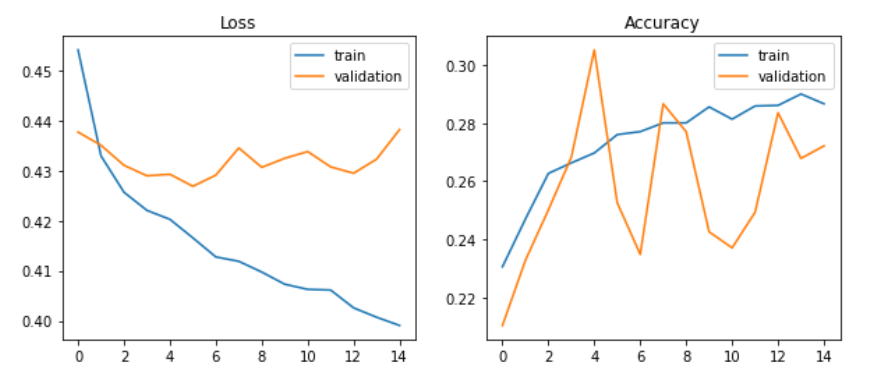

Koristimo Adam optimizator i binarnu unakrsnu entropiju kao funkciju greške. Veličina paketića je 128, broj epoha 40, a lr 0.001.

In [227]:
batch_size = 128
epochs = 40

In [228]:
model_resnet50.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
history = model_resnet50.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_validation,y_validation) )

C:\Users\Aleksandar\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/40
198/198 [==============================] - 492s 2s/step - loss: 0.4651 - accuracy: 0.2148 - val_loss: 0.4291 - val_accuracy: 0.2667
Epoch 2/40
198/198 [==============================] - 465s 2s/step - loss: 0.4364 - accuracy: 0.2550 - val_loss: 0.4277 - val_accuracy: 0.2873
Epoch 3/40
198/198 [==============================] - 469s 2s/step - loss: 0.4308 - accuracy: 0.2656 - val_loss: 0.4270 - val_accuracy: 0.2761
Epoch 4/40
198/198 [==============================] - 464s 2s/step - loss: 0.4260 - accuracy: 0.2774 - val_loss: 0.4272 - val_accuracy: 0.2452
Epoch 5/40
198/198 [==============================] - 465s 2s/step - loss: 0.4226 - accuracy: 0.2728 - val_loss: 0.4261 - val_accuracy: 0.2948
Epoch 6/40
198/198 [==============================] - 465s 2s/step - loss: 0.4183 - accuracy: 0.2810 - val_loss: 0.4277 - val_accuracy: 0.3006
Epoch 7/40
198/198 [==============================] - 466s 2s/step - loss: 0.4156 - accuracy: 0.2841 - val_loss: 0.4250 - val_accuracy: 0.2831

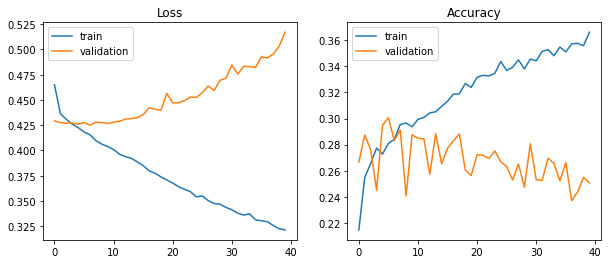

In [229]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(0, epochs), history.history['loss'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_loss'], label='validation')
plt.legend(loc='best')


plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(np.arange(0, epochs), history.history['accuracy'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_accuracy'], label='validation')
plt.legend(loc='best')

plt.show()

I nakon dodate reguralizacije vidimo da se situacije nije mnogo popravila. Na trening skupu se smanjuje greška i raste preciznost, dok je na validacionom skupu obrnuto. Takođe uočavamo i velike oscilacije na validacionom skupu. Razlog ovome je možda varijabilnost u podacima, pa model viđa različite stvari na treningu i validaciji. Ipak ćemo uraditi evaluaciju modela da vidimo kakvi su ostali izlazni parametri.

## Evaluacija modela

In [230]:
y_predikcija=model_resnet50.predict(X_test)

164/164 [==============================] - 123s 741ms/step


Pošto smo koristili sigmoidnu funkciju, vrednost y_predikcija će biti vektor dužine 13 koji ima brojeve između 0 i 1.
Oni predstavljaju verovatnoću pripadanja odredjenoj klasi. Kako bismo dobili konačne vrednosti predikcije potrebno je da
brojeve koji su manji od 0.5 zamenimo sa 0, a oni koji su veći ili jednaki zamenimo sa 1.

Zbog losih rezultata koje model daje podsicemo i drugu promenljivu koja ce imati prag 0.3, odnosno ako je predvidjena verovatnoca za zanr veca od 0.3 smatracemo da film pripada tom zanru

In [242]:
y_pred=[] 
y_pred_03=[]

In [243]:
for i in y_predikcija:
  y_pred.append([1 if j>=0.5 else 0 for j in i ])# sa i se krecemo kroz y_predikcija, odnosno i predstavlja vektor dužine 13, 
#a sa j se krećemo kroz tih 13 brojeva i zamenjujemo ih jedinicom ili nulom u zavisnosti od toga da li su veci(i jednaki) od 0.5 ili manji.
  y_pred_03.append([1 if j>=0.3 else 0 for j in i ])

In [244]:
y_pred = np.array(y_pred)
y_pred_03=np.array(y_pred_03)
y_pred

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

U problemu višeklasne klasifikacije kod kog zavisna promenljiva može imati više klasa postoje različite tehnike evaluacije koje se mogu razlikovati od tehnika evaluacije za binarnu klasifikaciju. Prilikom poziva funkcije multilabel_confusion_matrix dobijamo više matrica konfuzije. Svaka matrica odgovara jednoj klasi i treba obratiti pažnju na to da je raspored elemenata u matrici drugačiji od standardne matrice konfuzije. U prvom redu nalaze se brojevi TN i FP, redom, a u drugom redu FN i TP. 


TN- broj koliko puta model nije predvideo određenu klasu i ta klasa nije ni trebalo da bude pogođena
FP- broj koliko je puta model predvideo određenu klasu, a ona nije bila tačna
FN- broj koliko puta model nije predvideo određenu klasu, a ona je bila tačna
TP- broj koliko je puta model predvideo određenu klasu i ona je bila tačna

In [245]:
multilabel_confusion_matrix(y_test, y_pred)

array([[[3308,  448],
        [1041,  448]],

       [[4274,  155],
        [ 732,   84]],

       [[4242,  213],
        [ 445,  345]],

       [[3135,  526],
        [1091,  493]],

       [[4384,   72],
        [ 765,   24]],

       [[2856,  511],
        [1474,  404]],

       [[4671,    6],
        [ 567,    1]],

       [[4244,   36],
        [ 942,   23]],

       [[4572,    7],
        [ 664,    2]],

       [[4489,   85],
        [ 616,   55]],

       [[4710,    4],
        [ 528,    3]],

       [[4568,   58],
        [ 599,   20]],

       [[4211,   39],
        [ 974,   21]]], dtype=int64)

In [246]:
multilabel_confusion_matrix(y_test, y_pred_03)

array([[[2547, 1209],
        [ 650,  839]],

       [[3918,  511],
        [ 604,  212]],

       [[4011,  444],
        [ 340,  450]],

       [[2405, 1256],
        [ 654,  930]],

       [[4178,  278],
        [ 680,  109]],

       [[1536, 1831],
        [ 559, 1319]],

       [[4620,   57],
        [ 557,   11]],

       [[4044,  236],
        [ 799,  166]],

       [[4532,   47],
        [ 655,   11]],

       [[4343,  231],
        [ 558,  113]],

       [[4666,   48],
        [ 512,   19]],

       [[4397,  229],
        [ 543,   76]],

       [[3909,  341],
        [ 849,  146]]], dtype=int64)

Preciznost i odziv za svaku klasu računaju se na isti način kao i inače. F1-score je harmonijska sredina preciznosti i odziva.

Precision = TP/(TP + FP) 

Recall = TP/(TP + FN) 

Macro avg od neke mere predstavlja prosek vrednosti te mere za sve klase. Micro avg računa preciznost, odziv i f1-score po poznatim formulama, ali umesto TP,TN,FP i FN za jednu klasu koristi ove vrednosti sabrane za sve klase. Samples avg računa svaku od mera evaluacije za sve instance redom i uprosečava ih.

In [247]:
print(classification_report(y_test, y_pred,target_names=imena_klasa))

              precision    recall  f1-score   support

      action       0.50      0.30      0.38      1489
   adventure       0.35      0.10      0.16       816
   animation       0.62      0.44      0.51       790
      comedy       0.48      0.31      0.38      1584
       crime       0.25      0.03      0.05       789
       drama       0.44      0.22      0.29      1878
     fantasy       0.14      0.00      0.00       568
      horror       0.39      0.02      0.04       965
     mystery       0.22      0.00      0.01       666
     romance       0.39      0.08      0.14       671
      sci-fi       0.43      0.01      0.01       531
       short       0.26      0.03      0.06       619
    thriller       0.35      0.02      0.04       995

   micro avg       0.47      0.16      0.23     12361
   macro avg       0.37      0.12      0.16     12361
weighted avg       0.40      0.16      0.20     12361
 samples avg       0.25      0.16      0.18     12361



C:\Users\Aleksandar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [248]:
print(classification_report(y_test, y_pred_03,target_names=imena_klasa))

              precision    recall  f1-score   support

      action       0.41      0.56      0.47      1489
   adventure       0.29      0.26      0.28       816
   animation       0.50      0.57      0.53       790
      comedy       0.43      0.59      0.49      1584
       crime       0.28      0.14      0.19       789
       drama       0.42      0.70      0.52      1878
     fantasy       0.16      0.02      0.03       568
      horror       0.41      0.17      0.24       965
     mystery       0.19      0.02      0.03       666
     romance       0.33      0.17      0.22       671
      sci-fi       0.28      0.04      0.06       531
       short       0.25      0.12      0.16       619
    thriller       0.30      0.15      0.20       995

   micro avg       0.40      0.36      0.37     12361
   macro avg       0.33      0.27      0.26     12361
weighted avg       0.35      0.36      0.33     12361
 samples avg       0.39      0.36      0.35     12361



C:\Users\Aleksandar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iako rezultati nisu zadovoljavajuci, smanjenem praga smo ih poboljsali sto se najvise vidi na promenljivoj odziv.

Accuracy_score predstavlja odnos broja tačno pogođenih predikcija i svih predikcija. 

In [249]:
accuracy_score(y_test,y_pred) 

0.020781696854146808

In [250]:
accuracy_score(y_test,y_pred_03) 

0.029551954242135366

Ovo je najstroža mera jer zahteva da bude pogođen svaki navedeni žanr filma. Kod modela koji mogu imati više tačnih klasa ne možemo isto tretirati predikciju koja nema pogođenu nijednu tačnu klasu i onu kod koje je bar nešto tačno, iz tog razloga koristi se blaža tehnika evaluacije koja se zove hamming_loss. Ona predstavlja odnos broja pogrešnih predviđanja u svim iteracijama i broja svih predviđanja ukupno. Model treba da ima što manji hamming_loss.

In [251]:
hamming_loss(y_test, y_pred)

0.18476204443792624

In [252]:
hamming_loss(y_test, y_pred_03) 

0.21526728752658209

In [253]:
model_resnet50.save('model_resnet50.h5')


Poboljšani podaci ne sređuju gresku preprilagođavanja modela koja nije zanemarljiva, stoga ovaj model nije najbolja opcija za rešavanje ovog zadatka. 